In [1]:
!nvidia-smi

Mon Sep 18 18:24:33 2017       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 375.66                 Driver Version: 375.66                    |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|===============================+======================+======================|
|   0  GeForce GTX 1080    Off  | 0000:04:00.0     Off |                  N/A |
| 27%   35C    P8    10W / 180W |    235MiB /  8114MiB |      0%      Default |
+-------------------------------+----------------------+----------------------+
|   1  GeForce GTX 1080    Off  | 0000:05:00.0     Off |                  N/A |
| 27%   36C    P8     9W / 180W |      2MiB /  8114MiB |      0%      Default |
+-------------------------------+----------------------+----------------------+
|   2  G

In [2]:
import os
os.environ["CUDA_VISIBLE_DEVICES"] = "7"
%matplotlib notebook
import importlib
import numpy as np
import pandas as pd
import keras
import sys
from keras.layers import TimeDistributed, Dense, Dropout, GRU, Bidirectional
from keras.models import Sequential
from tracker import extractor as ext, utils, metrics, visuals

Using Theano backend.
Using cuDNN version 5110 on context None
Mapped name None to device cuda: GeForce GTX 1080 (0000:0E:00.0)


In [3]:
%%time
modelpath = "data/models/ACTS-10N-25T-260R.h5"
filepath  = "data/sets/ACTS-10N-25T-16539E-260R.gz"
frame     = pd.read_csv(filepath)
events    = [event for (_, event) in frame.groupby("event_id", sort=False)]
percent   = 0.8
cutoff    = int(percent * len(events))
train, test = events[:cutoff], events[cutoff:]
print("Train is list of {} events.".format(len(train)))
print("Test is list of {} events.".format(len(test)))
print("Train takes up {} bytes.".format(sys.getsizeof(train)))
print("Test takes up {} bytes.".format(sys.getsizeof(test)))
if (not utils.is_prepared(train[0])) or (not utils.is_prepared(test[0])):
    print("Warning: frame is not prepared.")
    print("Look at the prepare_frame() function in tracker/extractor.py")
else:
    del frame  
    del events  # To save on memory.

Train is list of 13232 events.
Test is list of 3308 events.
Train takes up 105920 bytes.
Test takes up 26528 bytes.
CPU times: user 6.62 s, sys: 9.4 s, total: 16 s
Wall time: 16 s


In [4]:
order = ["phi", "r", "z"]

In [5]:
input_shape  = (260, 3)
n_categories = 25 + 2
optimizer    = keras.optimizers.RMSprop(lr=0.001)
histories    = []

In [6]:
model = keras.models.load_model(modelpath)

WARNING (theano.configdefaults): install mkl with `conda install mkl-service`: No module named 'mkl'


It seems that phi, r and z are all taken into account in whether a hit belongs to a track.

The K track is not full. It does not have hits passed layer radius 260. I will move a noise value to the next layer radius, 360, and adjust the noise hit's phi and z value such that it appears to belong to the K track.

Afterwards, I will change its z value to see if the model still classifies it to the K track. The model does not classify it to the K track if the z value does not align with the other members of the K track. (i.e. if its z is outside the range [500,1000].

I will then change its phi value to see if the model still classifies it to the K track. The model does not classify it to the K track if the r value does not align with the other members of the K track. (i.e. if it curves away from how the track is curving or if it curves too much in a way that does not align with the other hits)

In [9]:
frame = test[300].copy()
guess = model.predict(ext.extract_input([frame], order))[0]
print(metrics.percent_of_hits_assigned_correctly([frame], guesses=[guess], order=order))

0.972413793103


0.965517241379


<IPython.core.display.Javascript object>


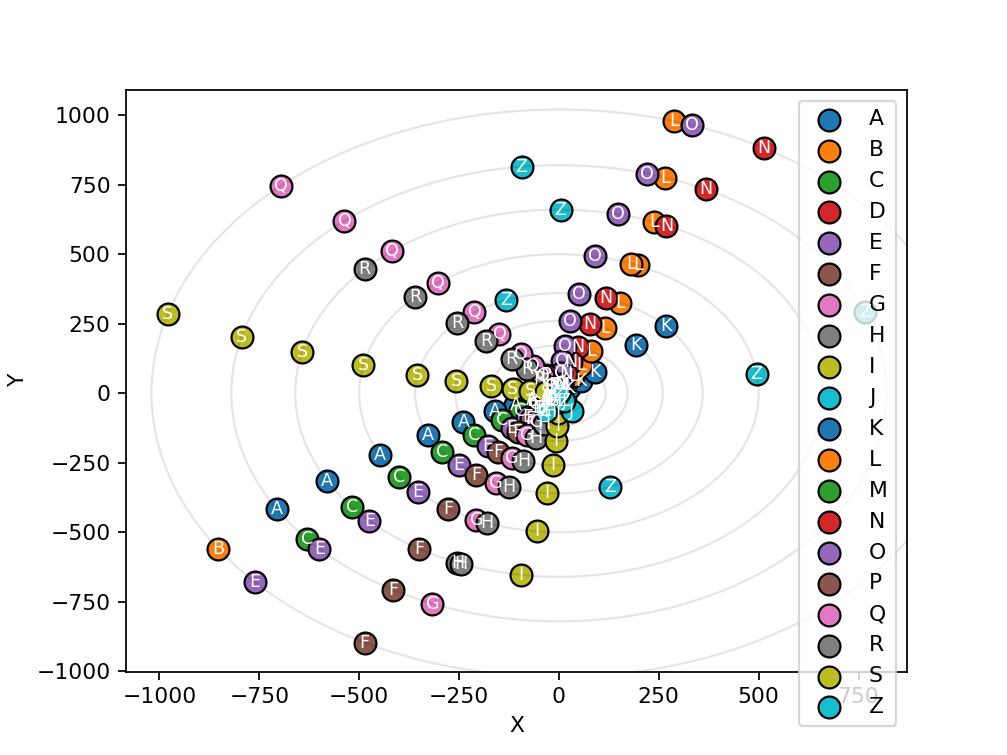

In [10]:
frame = test[300].copy()
frame.loc[3518579, "phi"] = 0.73
frame.loc[3518579, "r"] = 360
frame.loc[3518579, "z"] = 872
guess = model.predict(ext.extract_input([frame], order))[0]
print(metrics.percent_of_hits_assigned_correctly([frame], guesses=[guess], order=order))
visuals.Plot2D(frame, order, guess).plot(mode="xy")

0.972413793103


<IPython.core.display.Javascript object>


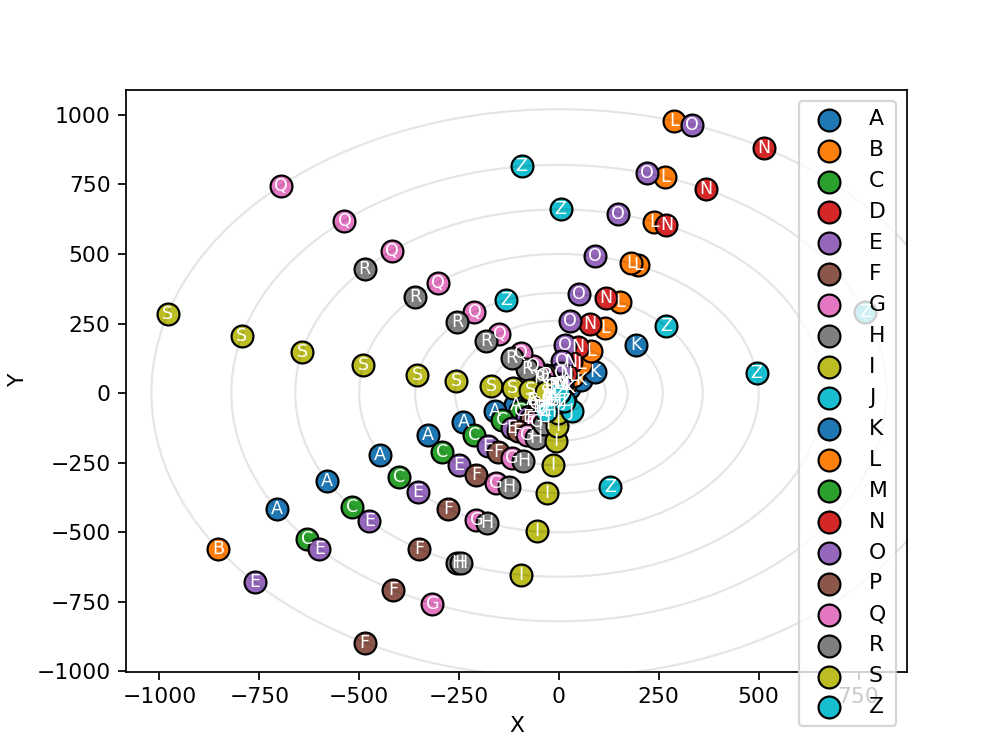

In [19]:
frame = test[300].copy()
frame.loc[3518579, "phi"] = 0.73
frame.loc[3518579, "r"] = 360
frame.loc[3518579, "z"] = 400
guess = model.predict(ext.extract_input([frame], order))[0]
print(metrics.percent_of_hits_assigned_correctly([frame], guesses=[guess], order=order))
visuals.Plot2D(frame, order, guess).plot(mode="xy")

0.972413793103


<IPython.core.display.Javascript object>


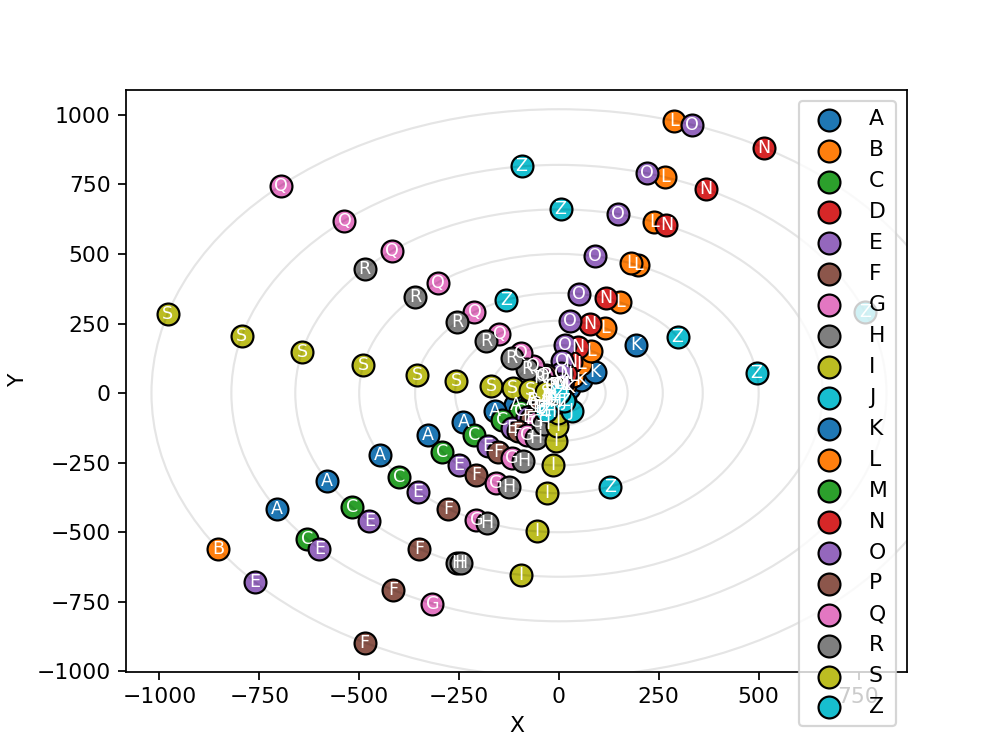

In [26]:
frame = test[300].copy()
frame.loc[3518579, "phi"] = 0.60
frame.loc[3518579, "r"] = 360
frame.loc[3518579, "z"] = 872
guess = model.predict(ext.extract_input([frame], order))[0]
print(metrics.percent_of_hits_assigned_correctly([frame], guesses=[guess], order=order))
visuals.Plot2D(frame, order, guess).plot(mode="xy")